<a href="https://colab.research.google.com/github/ZitouniNidhal/ObjectDetectionApp/blob/main/Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ce code installe l'outil uv, qui est un gestionnaire de paquets Python alternatif et rapide. L'option -q signifie silencieux, donc il ne montrera pas la sortie détaillée de l'installation

In [22]:
!pip install uv

In [23]:
!uv pip install -q torch torchvision matplotlib numpy seaborn scikit-learn plotly

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
from sklearn.manifold import TSNE
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import HTML, display
import time
import copy
# Configuration pour de meilleurs graphiques
plt.style.use('fivethirtyeight')
sns.set(style="whitegrid")
# Vérifier si CUDA est disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Appareil utilisé pour le calcul : {device}")

Appareil utilisé pour le calcul : cpu


In [26]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Définir les transformations pour les données
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Moyenne et écart-type du jeu de données MNIST
])

# Télécharger et charger le jeu de données d'entraînement
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Télécharger et charger le jeu de données de test
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Afficher quelques exemples d'images
def show_mnist_examples(dataset, num_examples=5):
    fig, axes = plt.subplots(1, num_examples, figsize=(12, 3))
    for i in range(num_examples):
        img, label = dataset[i]
        axes[i].imshow(img.squeeze(), cmap='gray')
        axes[i].set_title(f'Étiquette: {label}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

In [27]:


class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)  # Première couche entièrement connectée
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)       # Couche de sortie (10 classes pour MNIST)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

    def get_weights(self):
        # Retourne les poids du modèle sous forme de dictionnaire
        return {
            'fc1_weights': self.fc1.weight.detach().cpu(),
            'fc1_bias': self.fc1.bias.detach().cpu(),
            'fc2_weights': self.fc2.weight.detach().cpu(),
            'fc2_bias': self.fc2.bias.detach().cpu()
        }

# Créer le modèle et le déplacer sur le bon périphérique
model = SimpleNN().to(device)
print(model)

SimpleNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [28]:
def visualize_fc1_weights(weights, num_neurons=16, title="Poids de la première couche"):
    """
    Affiche les poids de la première couche dense sous forme d'images.

    Paramètres :
    - weights : tenseur ou tableau numpy de forme (nombre_neurones, 784)
    - num_neurons : nombre de neurones à visualiser (par défaut 16, organisés en grille 4x4)
    - title : titre du graphique
    """
    # Reformater les poids en images 28x28
    selected_weights = weights[:num_neurons, :].reshape(num_neurons, 28, 28)

    # Créer une grille de sous-graphiques
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.flatten()

    for i in range(num_neurons):
        im = axes[i].imshow(selected_weights[i], cmap='viridis')
        axes[i].set_title(f'Neurone {i+1}')
        axes[i].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

    # Ajouter une barre de couleur commune
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()

In [29]:
def visualize_weight_distribution(weights_dict, title="Distribution des poids du modèle"):
    """
    Affiche la distribution des poids de chaque couche du modèle.

    Paramètres :
    - weights_dict : dictionnaire contenant les poids (ex: {'fc1_weights': ..., 'fc2_weights': ...})
    - title : titre du graphique
    """
    plt.figure(figsize=(12, 6))

    for name, weights in weights_dict.items():
        if 'weights' in name:  # Ignorer les biais
            flat_weights = weights.numpy().flatten()
            sns.kdeplot(flat_weights, label=name, bw_adjust=0.5)

    plt.title(title)
    plt.xlabel('Valeur des poids')
    plt.ylabel('Densité')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

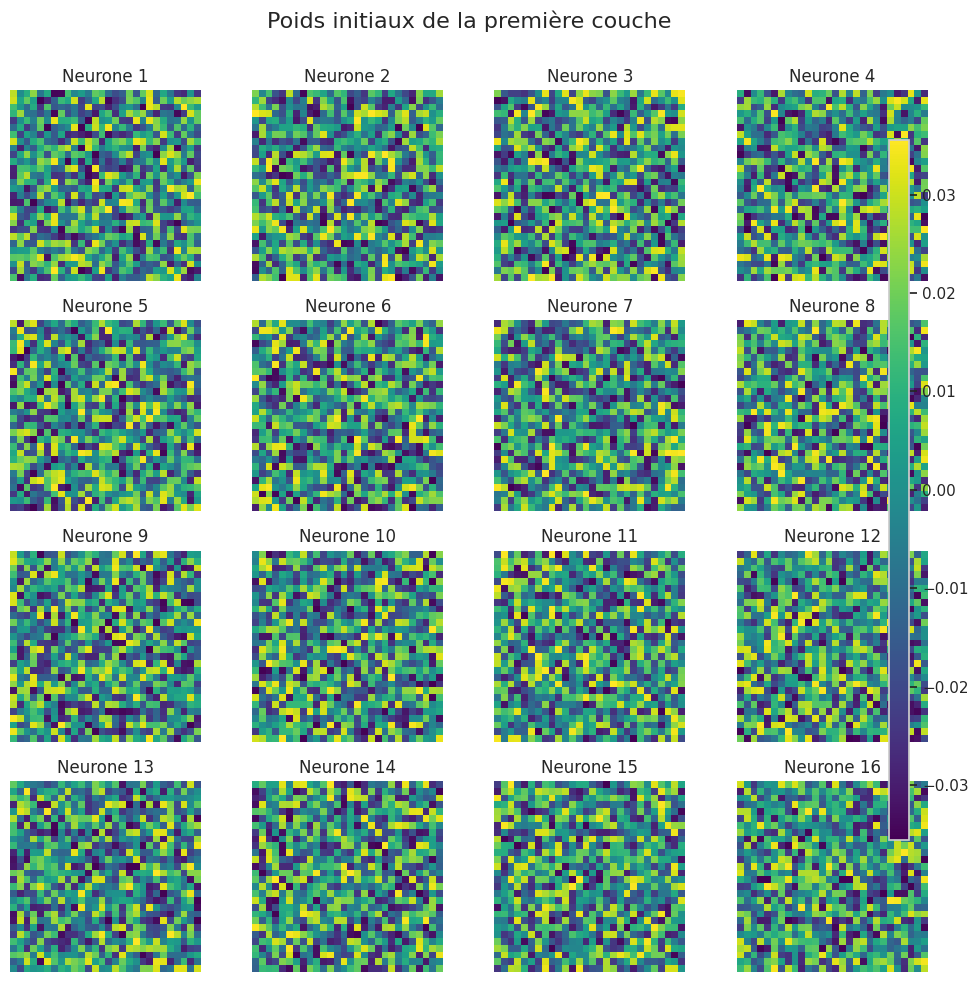

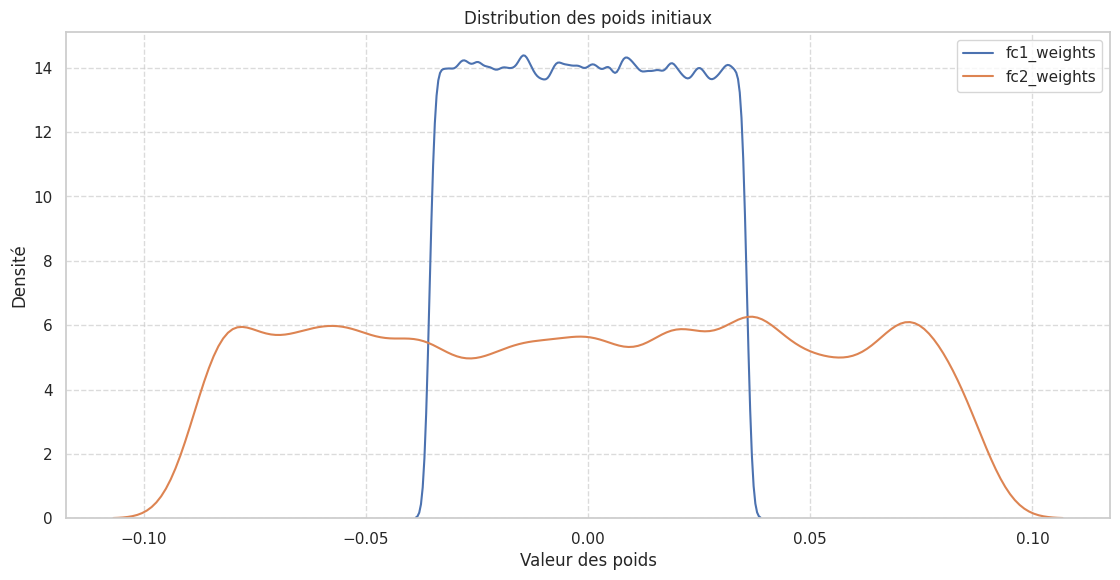

In [30]:
# Récupérer les poids initiaux du modèle
initial_weights = model.get_weights()

# Visualiser les poids de la première couche
visualize_fc1_weights(
    initial_weights['fc1_weights'],
    title="Poids initiaux de la première couche"
)

# Visualiser la distribution globale des poids
visualize_weight_distribution(
    initial_weights,
    title="Distribution des poids initiaux"
)

In [31]:
# Définition des hyperparamètres
num_epochs = 5
learning_rate = 0.001
# Définition de la fonction de perte et de l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Liste pour stocker les poids à différentes étapes
weights_over_time = []
# Fonction pour calculer la précision sur le jeu de test
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total
def train_model_with_tracking():
    model.train()
    history = {'train_loss': [], 'test_accuracy': []}

    # Sauvegarde des poids initiaux (avant tout entraînement)
    weights_over_time.append({
        'epoch': 0,
        'batch': 0,
        'weights': copy.deepcopy(model.get_weights()),
        'accuracy': evaluate_model(model, test_loader)
    })

    print("Entraînement du modèle...")

    for epoch in range(num_epochs):
        running_loss = 0.0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Toutes les 100 itérations : enregistrer les poids et évaluer
            if batch_idx % 100 == 99:
                avg_loss = running_loss / 100
                print(f'Époque [{epoch+1}/{num_epochs}], Lot [{batch_idx+1}/{len(train_loader)}], Perte: {avg_loss:.4f}')

                accuracy = evaluate_model(model, test_loader)
                weights_over_time.append({
                    'epoch': epoch + 1,
                    'batch': batch_idx + 1,
                    'weights': copy.deepcopy(model.get_weights()),
                    'accuracy': accuracy
                })

                history['train_loss'].append(avg_loss)
                history['test_accuracy'].append(accuracy)
                running_loss = 0.0

        # Évaluation finale à la fin de l’époque
        final_accuracy = evaluate_model(model, test_loader)
        print(f'Époque [{epoch+1}/{num_epochs}], Précision sur le jeu de test: {final_accuracy:.4f}')

    print("Entraînement terminé !")
    return history
# Entraîner le modèle et suivre les performances
history = train_model_with_tracking()


Entraînement du modèle...
Époque [1/5], Lot [100/938], Perte: 0.6175
Époque [1/5], Lot [200/938], Perte: 0.3258
Époque [1/5], Lot [300/938], Perte: 0.2655
Époque [1/5], Lot [400/938], Perte: 0.2316
Époque [1/5], Lot [500/938], Perte: 0.2210
Époque [1/5], Lot [600/938], Perte: 0.1928
Époque [1/5], Lot [700/938], Perte: 0.1644
Époque [1/5], Lot [800/938], Perte: 0.1620
Époque [1/5], Lot [900/938], Perte: 0.1385
Époque [1/5], Précision sur le jeu de test: 0.9582
Époque [2/5], Lot [100/938], Perte: 0.1243
Époque [2/5], Lot [200/938], Perte: 0.1175
Époque [2/5], Lot [300/938], Perte: 0.1240
Époque [2/5], Lot [400/938], Perte: 0.1136
Époque [2/5], Lot [500/938], Perte: 0.1067
Époque [2/5], Lot [600/938], Perte: 0.1041
Époque [2/5], Lot [700/938], Perte: 0.0908
Époque [2/5], Lot [800/938], Perte: 0.1073
Époque [2/5], Lot [900/938], Perte: 0.1119
Époque [2/5], Précision sur le jeu de test: 0.9707
Époque [3/5], Lot [100/938], Perte: 0.0811
Époque [3/5], Lot [200/938], Perte: 0.0797
Époque [3/5]

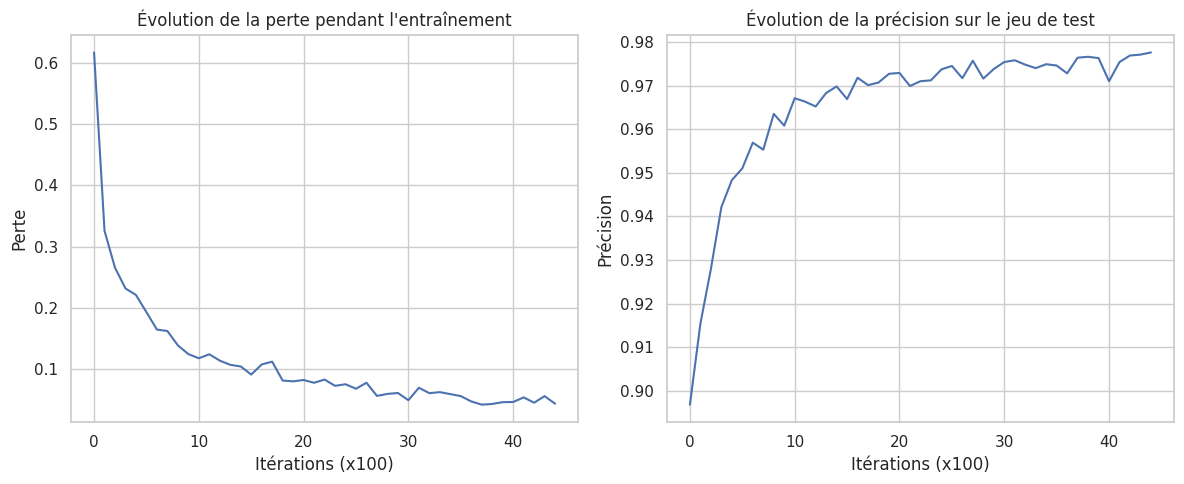

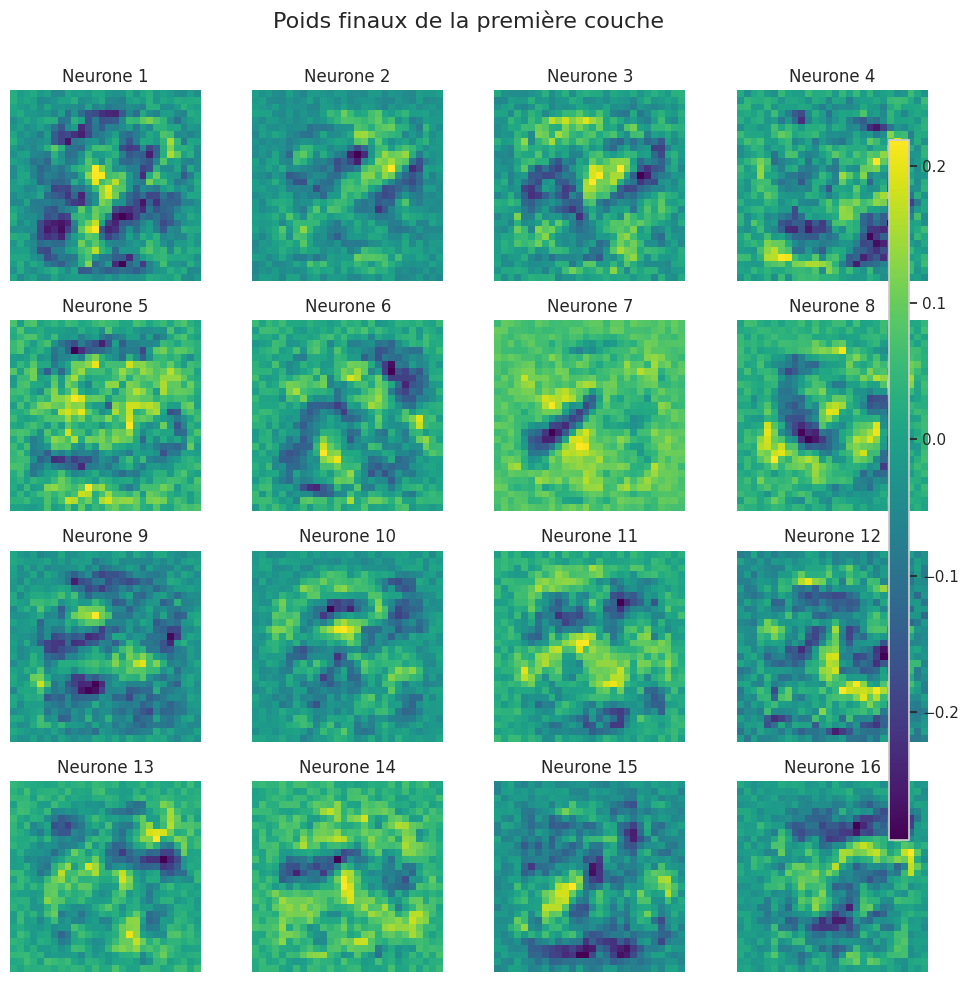

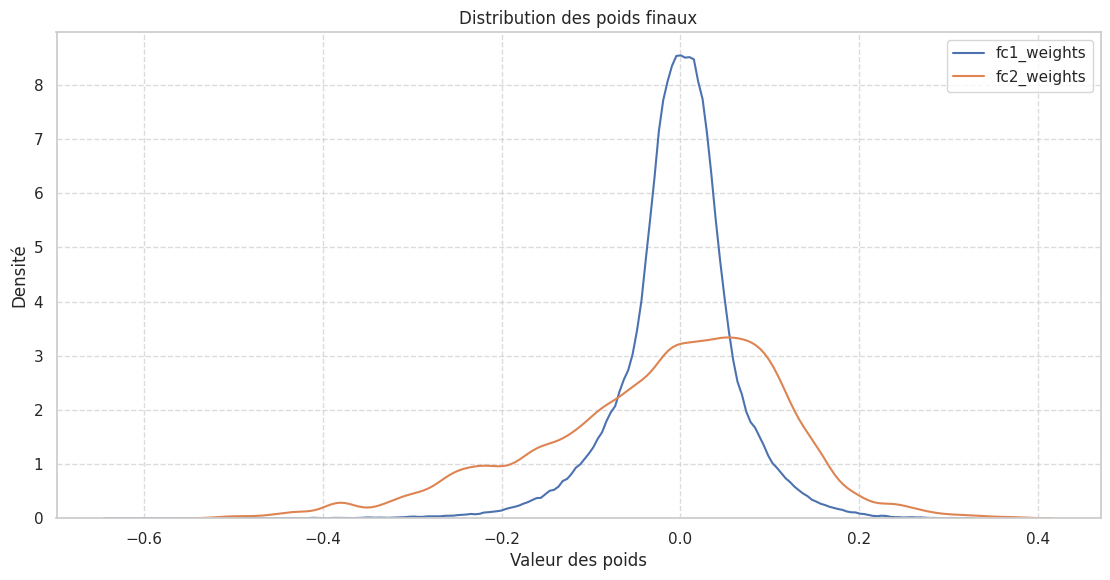

In [32]:
# Visualiser l'évolution de la perte et de la précision
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'])
plt.title('Évolution de la perte pendant l\'entraînement')
plt.xlabel('Itérations (x100)')
plt.ylabel('Perte')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history['test_accuracy'])
plt.title('Évolution de la précision sur le jeu de test')
plt.xlabel('Itérations (x100)')
plt.ylabel('Précision')
plt.grid(True)
plt.tight_layout()
plt.show()
# Visualiser les poids finaux
final_weights = model.get_weights()
visualize_fc1_weights(final_weights['fc1_weights'], title="Poids finaux de la première couche")
visualize_weight_distribution(final_weights, title="Distribution des poids finaux")

In [33]:
import matplotlib.animation as animation
from IPython.display import HTML, display

def create_weight_evolution_animation():
    """
    Crée une animation montrant l'évolution des poids de la première couche
    (fc1_weights) au fil de l'entraînement.

    Seuls les 4 premiers neurones sont visualisés pour plus de clarté.
    """
    # Neurones à visualiser
    selected_neurons = [0, 1, 2, 3]
    num_frames = len(weights_over_time)

    # Configuration de la figure
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()

    # Fonction d'initialisation (appelée une fois au début)
    def init():
        for i in range(len(selected_neurons)):
            axes[i].clear()
            axes[i].set_title(f'Neurone {selected_neurons[i] + 1}')
            axes[i].axis('off')
        return axes

    # Fonction de mise à jour pour chaque image (frame)
    def update(frame):
        # Récupérer les poids sauvegardés à cette étape
        weights = weights_over_time[frame]['weights']['fc1_weights']

        for i, neuron_idx in enumerate(selected_neurons):
            # Reformater les poids en image 28x28
            neuron_weights = weights[neuron_idx].reshape(28, 28)
            axes[i].clear()
            axes[i].imshow(neuron_weights, cmap='viridis')
            axes[i].set_title(
                f'Neurone {neuron_idx + 1}\n'
                f'Époque {weights_over_time[frame]["epoch"]}, '
                f'Lot {weights_over_time[frame]["batch"]}\n'
                f'Précision : {weights_over_time[frame]["accuracy"]:.4f}'
            )
            axes[i].axis('off')

        plt.suptitle(f'Évolution des poids pendant l\'entraînement — Frame {frame + 1}/{num_frames}', fontsize=16)
        return axes

    # Créer l'animation
    anim = animation.FuncAnimation(
        fig, update, frames=num_frames,
        init_func=init, blit=False, repeat=True
    )

    plt.tight_layout()
    plt.close(fig)  # Évite l'affichage statique en double dans Jupyter

    # Convertir en HTML5 pour affichage interactif
    return HTML(anim.to_jshtml())

In [34]:
# Générer et afficher l'animation dans le notebook
animation_html = create_weight_evolution_animation()
display(animation_html)

<Figure size 640x480 with 0 Axes>


--- Visualisation pour l'image 0 ---


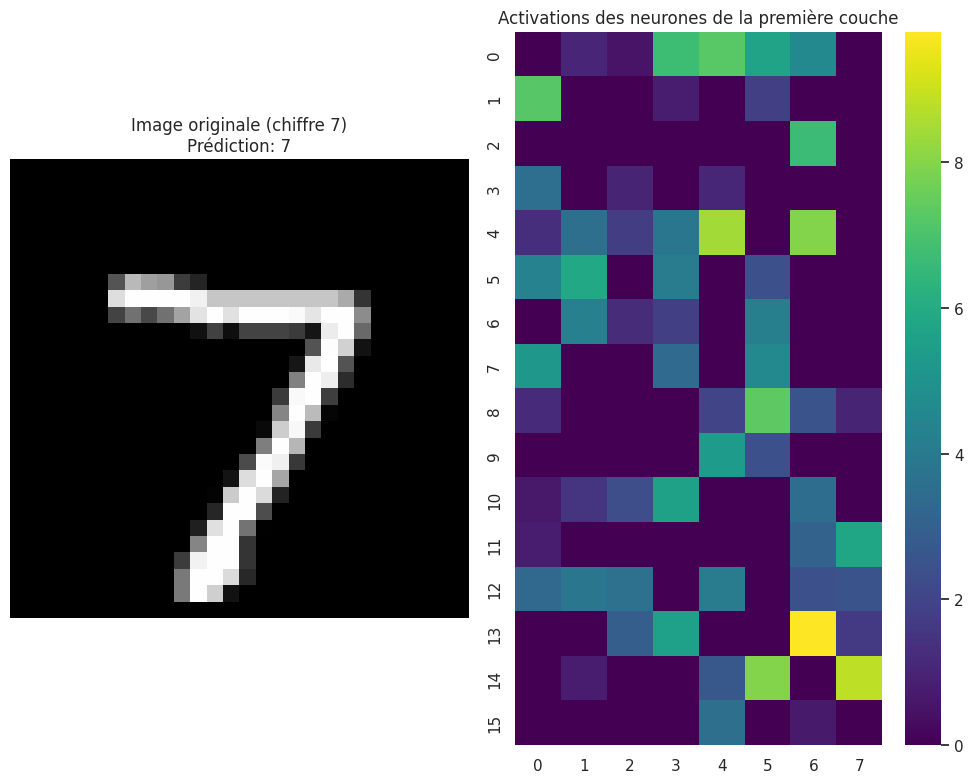

Forme des activations: (128,)
Activation max: 9.791
Activation moyenne: 1.755

--- Visualisation pour l'image 1 ---


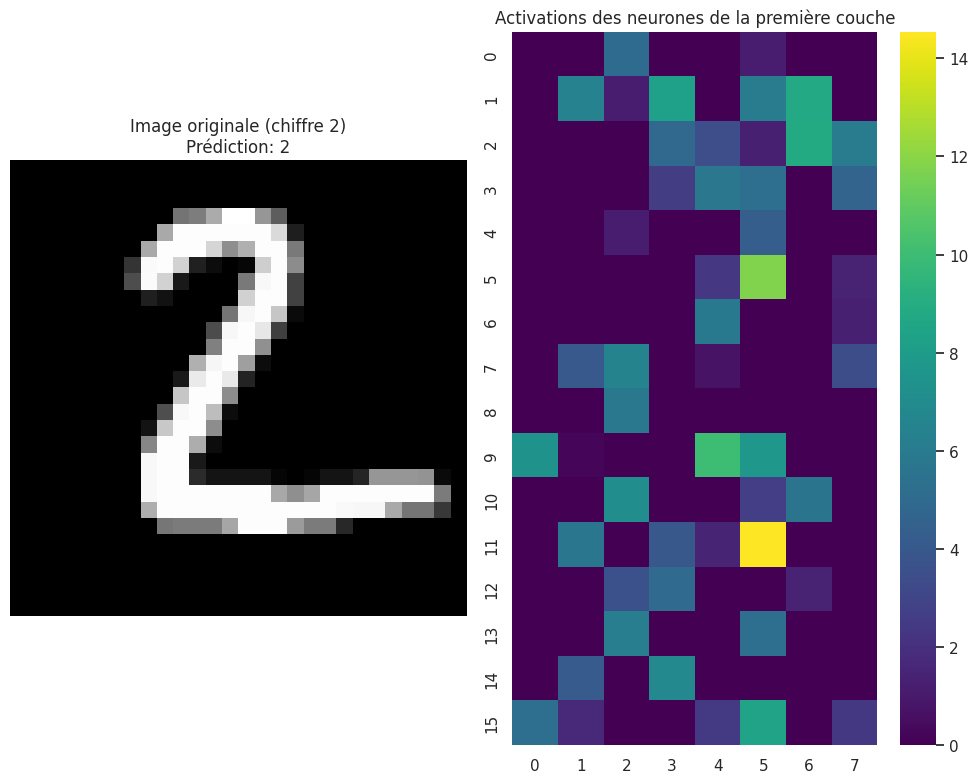

Forme des activations: (128,)
Activation max: 14.542
Activation moyenne: 1.925

--- Visualisation pour l'image 2 ---


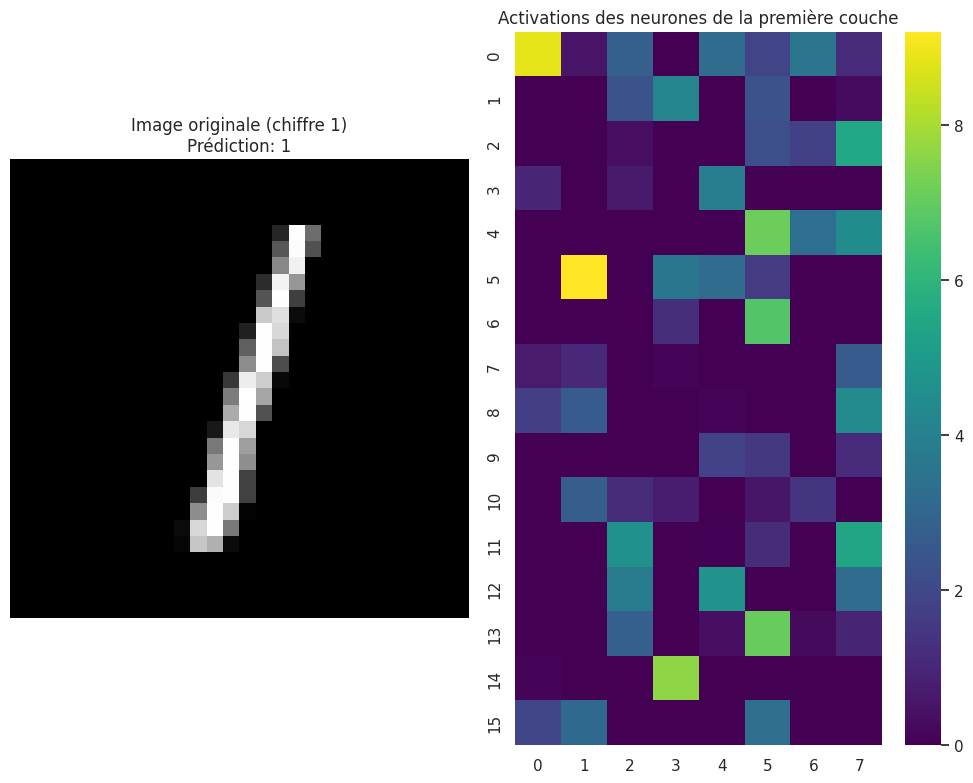

Forme des activations: (128,)
Activation max: 9.206
Activation moyenne: 1.258

--- Visualisation pour l'image 3 ---


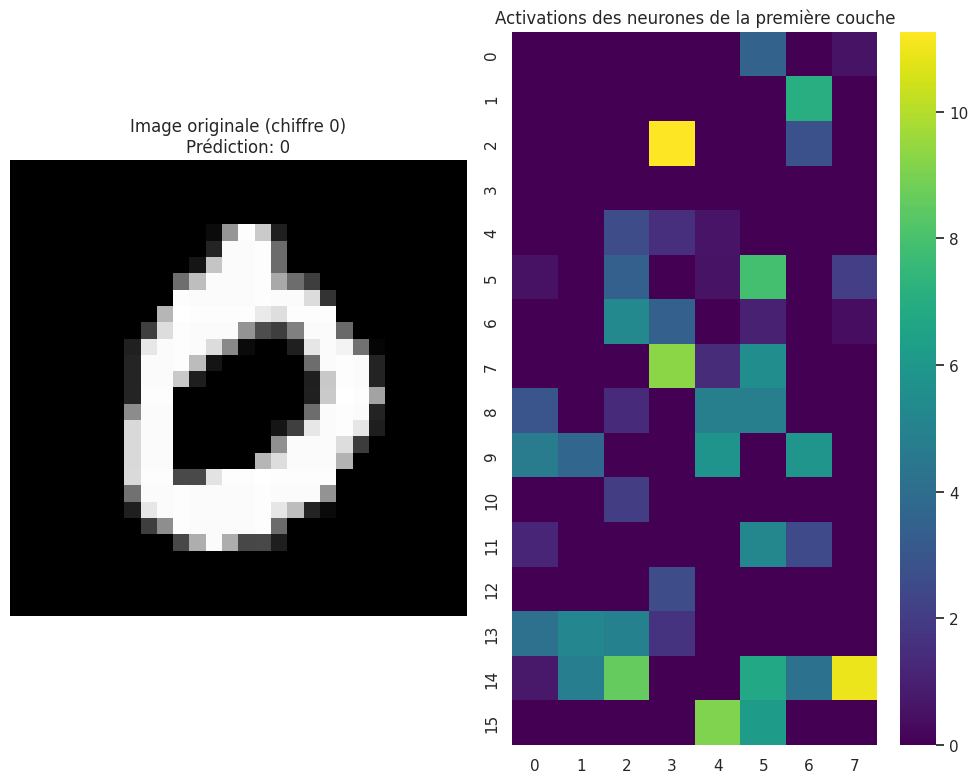

Forme des activations: (128,)
Activation max: 11.263
Activation moyenne: 1.446

--- Visualisation pour l'image 4 ---


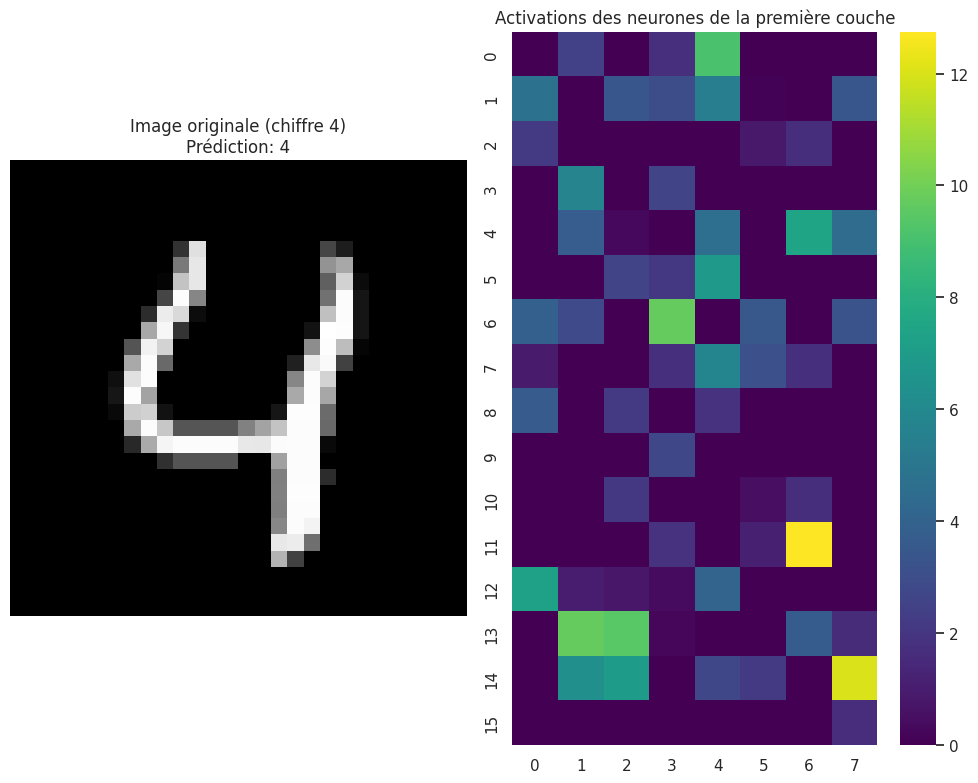

Forme des activations: (128,)
Activation max: 12.747
Activation moyenne: 1.679


In [35]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Fonction pour visualiser les filtres de la première couche (à définir)
def visualize_fc1_weights(weights, num_neurons=16, title="Filtres appris par la première couche"):
    """
    Visualise les poids/filtres de la première couche fully connected
    """
    # Adaptation selon le format des poids (ex: pour MNIST 784->28x28)
    input_size = weights.shape[0]
    img_size = int(np.sqrt(input_size))

    plt.figure(figsize=(15, 10))
    for i in range(min(num_neurons, weights.shape[1])):
        neuron_weights = weights[:, i].reshape(img_size, img_size)
        plt.subplot(4, 4, i+1)
        plt.imshow(neuron_weights.detach().cpu().numpy(), cmap='viridis', aspect='auto')
        plt.title(f'Neurone {i}')
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Fonction pour visualiser les réponses des neurones à une image spécifique
def visualize_neuron_activations(model, test_dataset, device, image_idx=0):
    """
    Visualise les activations des neurones de la première couche pour une image donnée
    """
    # Récupérer une image du jeu de test
    image, label = test_dataset[image_idx]
    image = image.unsqueeze(0).to(device)  # Ajouter la dimension du batch

    # Activer le mode d'évaluation
    model.eval()

    # Récupérer l'activation après la première couche
    activation = {}

    def get_activation(name):
        def hook(module, input, output):
            activation[name] = output.detach().cpu()
        return hook

    # Enregistrer le hook pour la première couche (ReLU)
    handle = model.relu.register_forward_hook(get_activation('relu'))

    # Passer l'image à travers le modèle
    with torch.no_grad():
        output = model(image)
        prediction = torch.argmax(output, dim=1).item()

    # Supprimer le hook
    handle.remove()

    # Récupérer les activations
    activations = activation['relu'].squeeze().numpy()

    # Visualiser l'image originale et les activations des neurones
    plt.figure(figsize=(10, 8))

    # Afficher l'image originale
    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze().cpu().numpy(), cmap='gray')
    plt.title(f'Image originale (chiffre {label})\nPrédiction: {prediction}')
    plt.axis('off')

    # Afficher les activations des neurones sous forme de heatmap
    plt.subplot(1, 2, 2)
    # Reformater pour une meilleure visualisation (adapter selon vos dimensions)
    try:
        activation_reshaped = activations.reshape(16, 8)  # 16 neurones x 8 valeurs
        sns.heatmap(activation_reshaped, cmap='viridis', annot=False)
    except:
        # Fallback si la reshape échoue
        plt.imshow(activations.reshape(1, -1), cmap='viridis', aspect='auto')

    plt.title('Activations des neurones de la première couche')
    plt.tight_layout()
    plt.show()

    return activations

# Utilisation principale
if __name__ == "__main__":
    # Supposons que model, test_dataset, et device sont déjà définis

    # 1. Visualiser tous les filtres de la première couche après l'entraînement
    # Note: adapter l'accès aux poids selon votre modèle
    # fc1_weights = model.fc1.weight  # ou autre méthode d'accès
    # visualize_fc1_weights(fc1_weights, num_neurons=16,
    #                       title="Filtres appris par la première couche")

    # 2. Visualiser les activations pour quelques exemples
    for i in range(5):
        print(f"\n--- Visualisation pour l'image {i} ---")
        activations = visualize_neuron_activations(model, test_dataset, device, i)
        print(f"Forme des activations: {activations.shape}")
        print(f"Activation max: {np.max(activations):.3f}")
        print(f"Activation moyenne: {np.mean(activations):.3f}")

In [36]:
# Fonction pour créer et entraîner un modèle avec une initialisation spécifique
def train_model_with_init(init_method, epochs=3):
    # Créer un nouveau modèle
    model = SimpleNN().to(device)

    # Appliquer l'initialisation spécifiée
    if init_method == "zeros":
        nn.init.zeros_(model.fc1.weight)
        nn.init.zeros_(model.fc2.weight)
    elif init_method == "ones":
        nn.init.ones_(model.fc1.weight)
        nn.init.ones_(model.fc2.weight)
    elif init_method == "normal":
        nn.init.normal_(model.fc1.weight, mean=0.0, std=0.01)
        nn.init.normal_(model.fc2.weight, mean=0.0, std=0.01)
    elif init_method == "xavier":
        nn.init.xavier_uniform_(model.fc1.weight)
        nn.init.xavier_uniform_(model.fc2.weight)
    elif init_method == "kaiming":
        nn.init.kaiming_normal_(model.fc1.weight)
        nn.init.kaiming_normal_(model.fc2.weight)

    # Les biais sont initialisés à zéro par défaut

    # Définition de la fonction de perte et de l'optimiseur
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Liste pour stocker les performances
    history = {'train_loss': [], 'test_accuracy': []}

    # Visualiser les poids initiaux
    initial_weights = model.get_weights()

    # Entraîner le modèle
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if batch_idx % 100 == 99:
                avg_loss = running_loss / 100
                accuracy = evaluate_model(model, test_loader)
                history['train_loss'].append(avg_loss)
                history['test_accuracy'].append(accuracy)
                print(f'Init: {init_method}, Époque: {epoch+1}/{epochs}, Lot: {batch_idx+1}, Perte: {avg_loss:.4f}, Précision: {accuracy:.4f}')
                running_loss = 0.0

    # Évaluer le modèle final
    final_accuracy = evaluate_model(model, test_loader)
    print(f"Init: {init_method}, Précision finale: {final_accuracy:.4f}")
    return history, initial_weights, model.get_weights()

# Liste des méthodes d'initialisation à tester
init_methods = ["zeros", "normal", "xavier", "kaiming"]

# Dictionnaire pour stocker les résultats
results = {}

# Entraîner un modèle pour chaque méthode d'initialisation
for method in init_methods:
    print(f"\nEntraînement avec initialisation {method}...")
    history, init_weights, final_weights = train_model_with_init(method)
    results[method] = {
        'history': history,
        'init_weights': init_weights,
        'final_weights': final_weights
    }


Entraînement avec initialisation zeros...
Init: zeros, Époque: 1/3, Lot: 100, Perte: 1.9445, Précision: 0.4932
Init: zeros, Époque: 1/3, Lot: 200, Perte: 0.9502, Précision: 0.8440
Init: zeros, Époque: 1/3, Lot: 300, Perte: 0.4347, Précision: 0.8921
Init: zeros, Époque: 1/3, Lot: 400, Perte: 0.3468, Précision: 0.9072
Init: zeros, Époque: 1/3, Lot: 500, Perte: 0.2875, Précision: 0.9229
Init: zeros, Époque: 1/3, Lot: 600, Perte: 0.2540, Précision: 0.9258
Init: zeros, Époque: 1/3, Lot: 700, Perte: 0.2429, Précision: 0.9337
Init: zeros, Époque: 1/3, Lot: 800, Perte: 0.2420, Précision: 0.9369
Init: zeros, Époque: 1/3, Lot: 900, Perte: 0.2060, Précision: 0.9427
Init: zeros, Époque: 2/3, Lot: 100, Perte: 0.1636, Précision: 0.9466
Init: zeros, Époque: 2/3, Lot: 200, Perte: 0.1683, Précision: 0.9467
Init: zeros, Époque: 2/3, Lot: 300, Perte: 0.1672, Précision: 0.9503
Init: zeros, Époque: 2/3, Lot: 400, Perte: 0.1668, Précision: 0.9480
Init: zeros, Époque: 2/3, Lot: 500, Perte: 0.1841, Précision

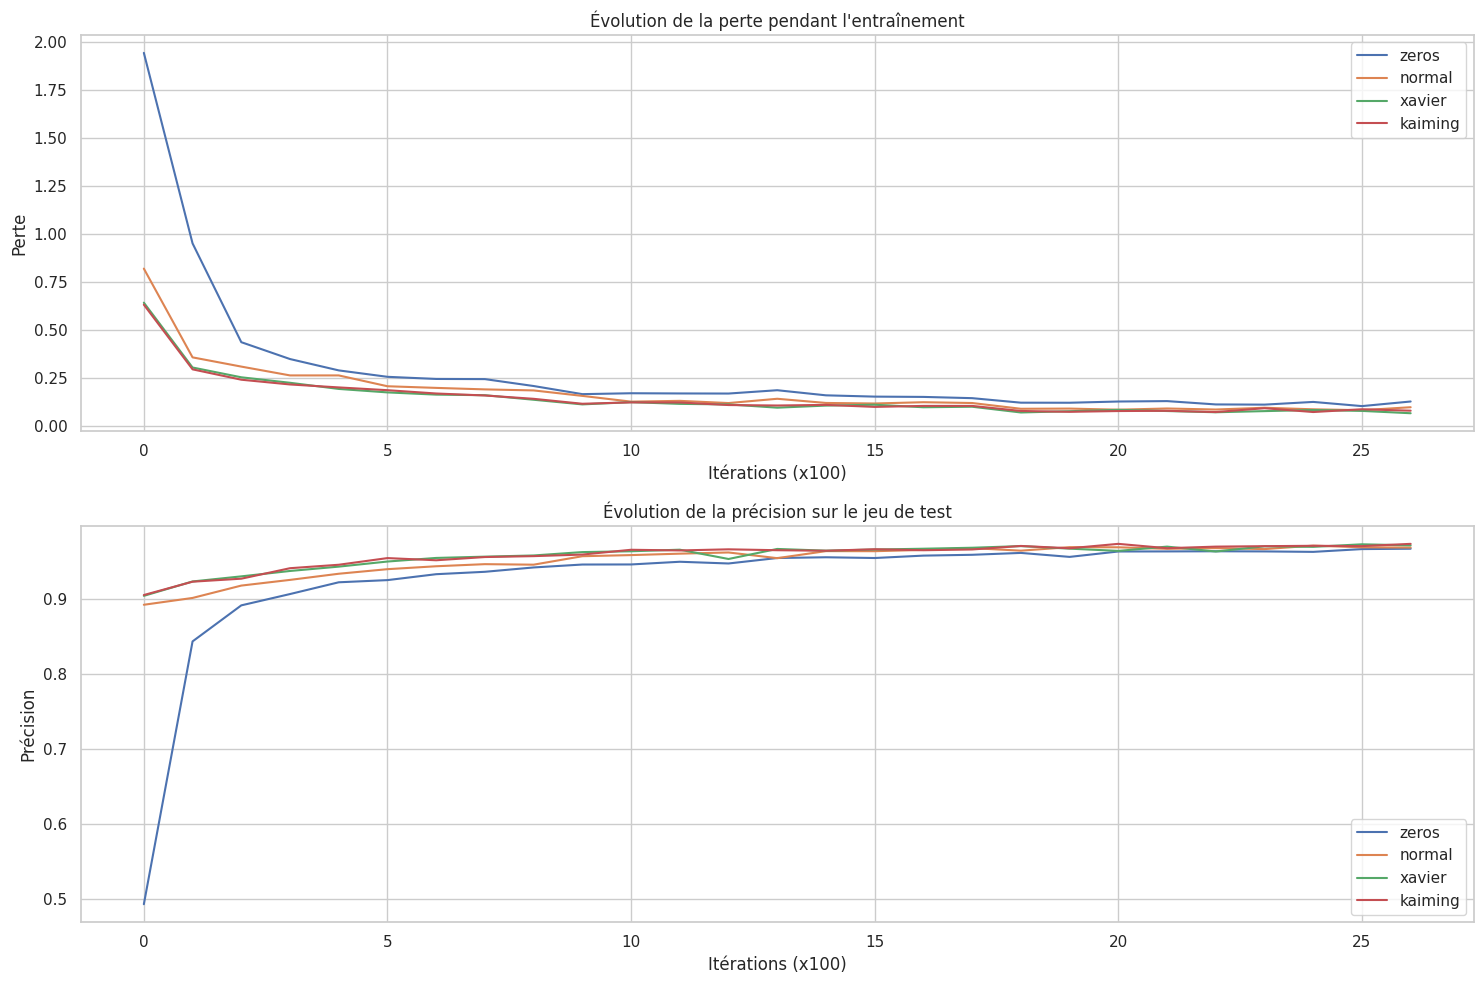

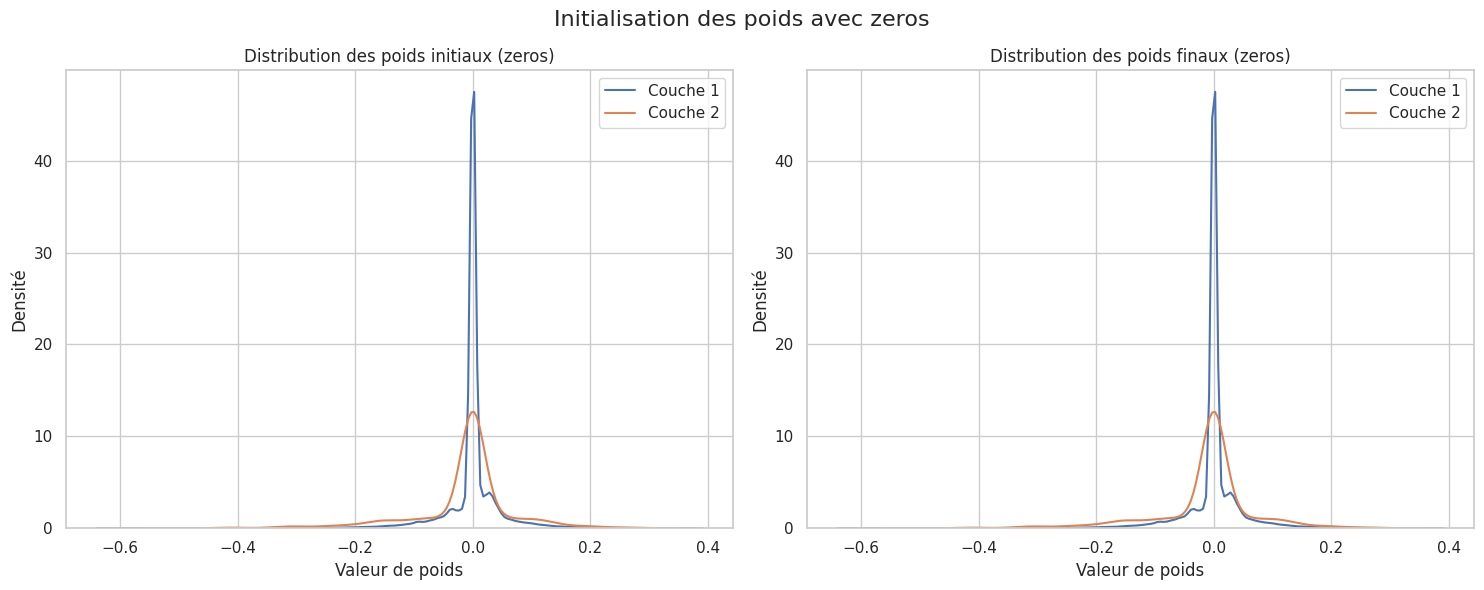

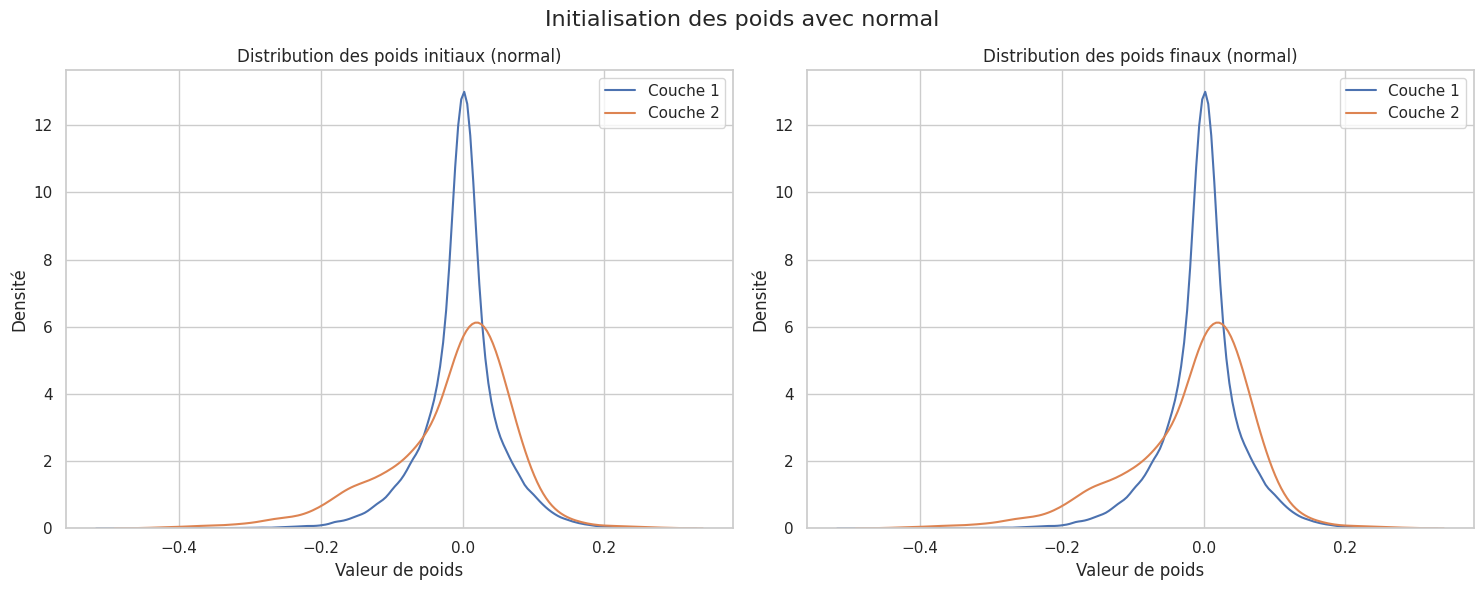

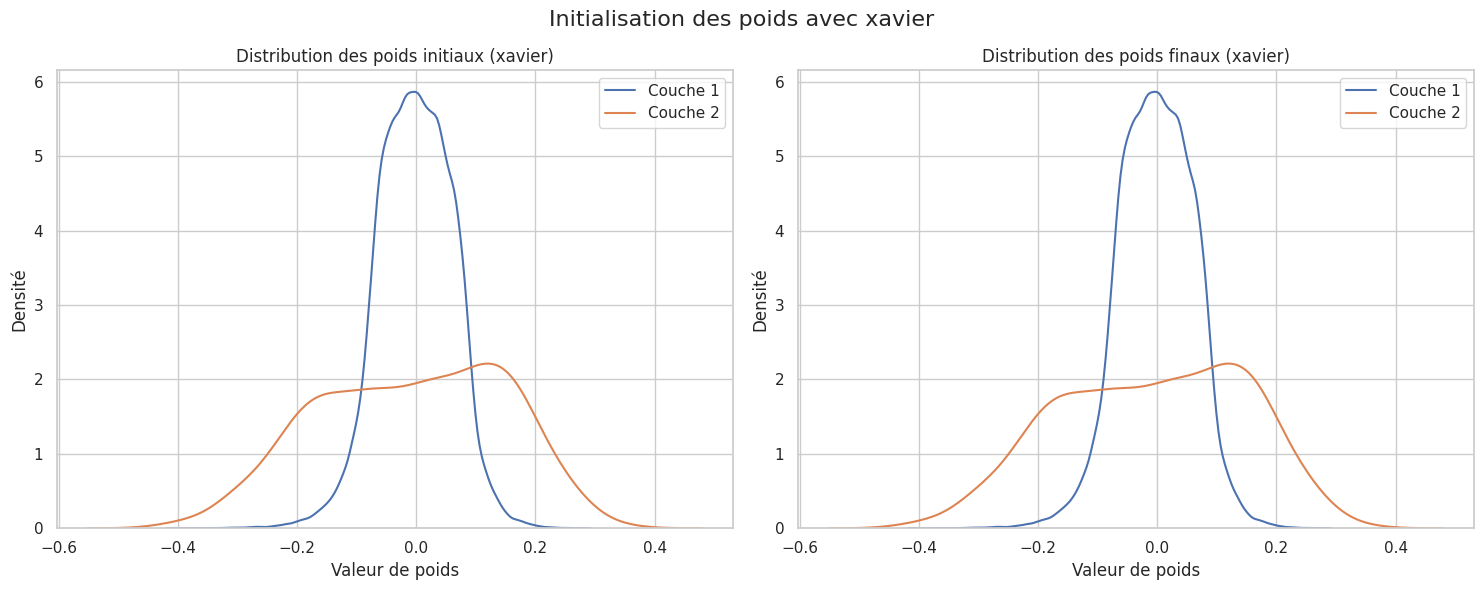

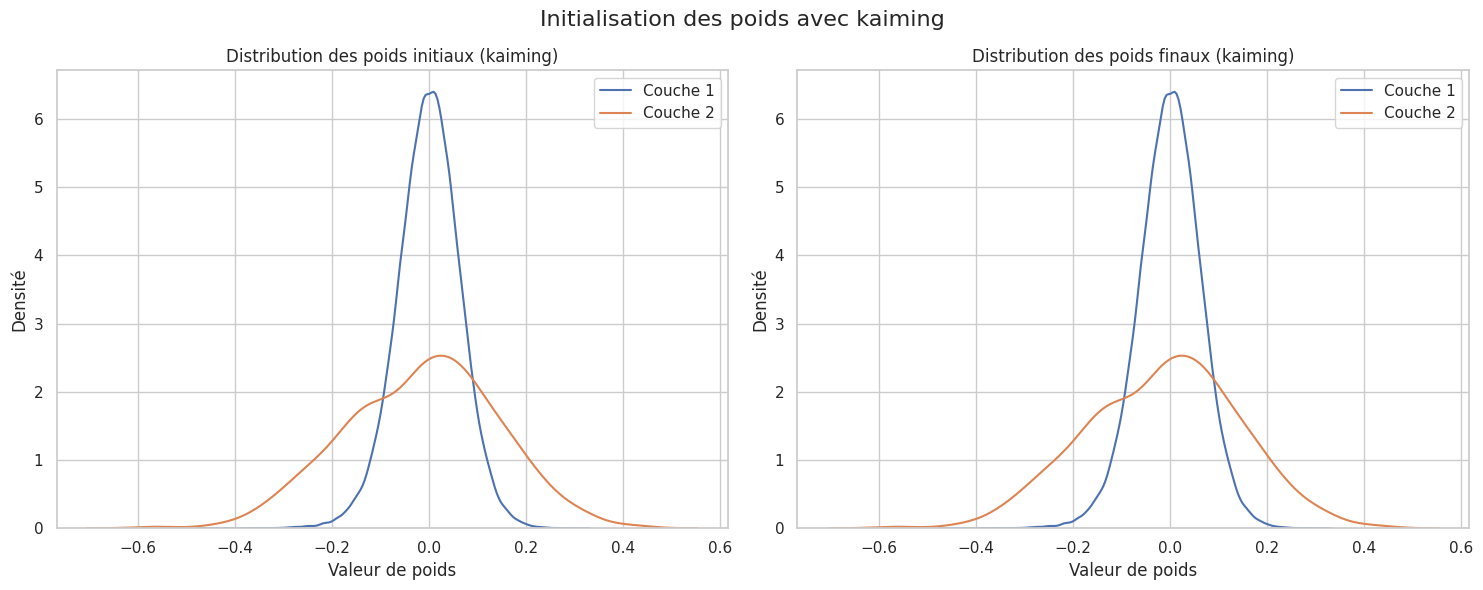

In [38]:
# Visualiser les performances des différentes initialisations
plt.figure(figsize=(15, 10))

# Graphique de la perte d'entraînement
plt.subplot(2, 1, 1)
for method in init_methods:
    plt.plot(results[method]['history']['train_loss'], label=method)
plt.title('Évolution de la perte pendant l\'entraînement')
plt.xlabel('Itérations (x100)')
plt.ylabel('Perte')
plt.legend()
plt.grid(True)

# Graphique de la précision de test
plt.subplot(2, 1, 2)
for method in init_methods:
    plt.plot(results[method]['history']['test_accuracy'], label=method)
plt.title('Évolution de la précision sur le jeu de test')
plt.xlabel('Itérations (x100)')
plt.ylabel('Précision')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualiser les poids initiaux et finaux pour chaque méthode
for method in init_methods:
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    sns.kdeplot(results[method]['init_weights']['fc1_weights'].numpy().flatten(),
                label='Couche 1')
    sns.kdeplot(results[method]['init_weights']['fc2_weights'].numpy().flatten(),
                label='Couche 2')
    plt.title(f'Distribution des poids initiaux ({method})')
    plt.xlabel('Valeur de poids')
    plt.ylabel('Densité')
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.kdeplot(results[method]['final_weights']['fc1_weights'].numpy().flatten(),
                label='Couche 1')
    sns.kdeplot(results[method]['final_weights']['fc2_weights'].numpy().flatten(),
                label='Couche 2')
    plt.title(f'Distribution des poids finaux ({method})')
    plt.xlabel('Valeur de poids')
    plt.ylabel('Densité')
    plt.legend()

    plt.suptitle(f'Initialisation des poids avec {method}', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

Application de t-SNE pour réduire la dimensionnalité...


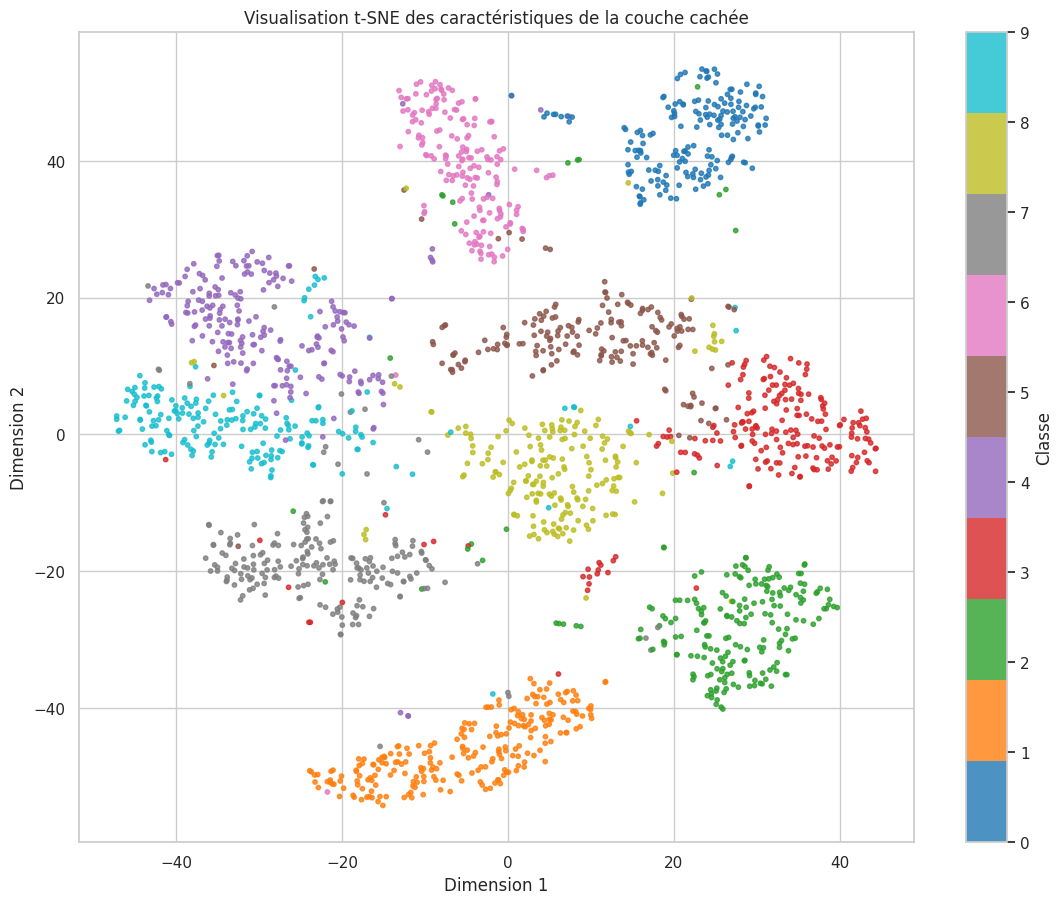

In [39]:

# Fonction pour extraire les caractéristiques de la couche cachée
def extract_features(model, dataloader, num_samples=1000):
    model.eval()
    features = []
    labels = []
    count = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            batch_size = inputs.size(0)

            # Si on a déjà suffisamment d'échantillons, on arrête
            if count + batch_size > num_samples:
                remaining = num_samples - count
                inputs = inputs[:remaining]
                targets = targets[:remaining]

            # Extraire les activations de la couche cachée
            x = model.flatten(inputs)
            x = model.fc1(x)
            x = model.relu(x)

            features.append(x.cpu().numpy())
            labels.append(targets.numpy())
            count += inputs.size(0)

            if count >= num_samples:
                break

    features = np.vstack(features)
    labels = np.concatenate(labels)
    return features, labels

# Extraire les caractéristiques
features, labels = extract_features(model, test_loader, num_samples=2000)

# Appliquer t-SNE pour réduire la dimensionnalité
print("Application de t-SNE pour réduire la dimensionnalité...")
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

# Visualiser les résultats
plt.figure(figsize=(12, 10))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10',
                     alpha=0.8, s=10)
plt.colorbar(scatter, label='Classe')
plt.title('Visualisation t-SNE des caractéristiques de la couche cachée')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

# Visualiser avec Plotly pour une visualisation interactive
fig = px.scatter(
    x=features_2d[:, 0],
    y=features_2d[:, 1],
    color=[f"{l}" for l in labels],
    title='Visualisation t-SNE des caractéristiques (interactif)',
    labels={'color': 'Classe', 'x': 'Dimension 1', 'y': 'Dimension 2'}
)
fig.update_layout(legend_title_text='Classe')
fig.show()